# Build a Conditional GAN

### Goals
In this notebook, you're going to make a conditional GAN in order to generate hand-written images of digits, conditioned on the digit to be generated (the class vector). This will let you choose what digit you want to generate.

You'll then do some exploration of the generated images to visualize what the noise and class vectors mean.  

### Learning Objectives
1.   Learn the technical difference between a conditional and unconditional GAN.
2.   Understand the distinction between the class and noise vector in a conditional GAN.



In [16]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!
torch.backends.mps.is_built()



True

In [17]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [18]:
# Generator class
class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan = 1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)

        )

    def  make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride = 2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels ,kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True)
            )
        else: return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels ,kernel_size, stride),
            nn.Tanh()
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.input_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_sample, input_dim, device='cpu'):
    return torch.randn(n_sample, input_dim, device=device)


In [19]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, im_chan = 1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels , output_channels, kernel_size=4, stride=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels ,kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace = True)
            )
        else: return nn.Sequential(
            nn.Conv2d(input_channels, output_channels ,kernel_size, stride),
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [20]:
# conditoned vector creation

import torch.nn.functional as F

def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels, n_classes)

assert (
    get_one_hot_labels(
        labels=torch.Tensor([0, 2, 1]).long(), 
        n_classes=3).tolist() == [
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
])

print('Success...')

Success...


In [21]:
def combine_vectors(x, y):
    return torch.cat((x.float(), y.float()), 1)

combined = combine_vectors(torch.tensor([[1, 2],[3, 4]]), torch.tensor([[5,6],[7, 8]]))
assert torch.all(combined == torch.tensor([[1, 2, 5,6], [3, 4, 7, 8]]))
assert (type(combined[0][0].item()) == float)
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5))
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
print("Success!")

Success!


In [44]:
mnist_shape = (1, 28, 28)
n_classes = 10

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
# device = 'cpu'
device = torch.device("mps")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [45]:
def get_input_dimension(z_dim, mnist_shape, n_classes):
    gen_input_dim = z_dim + n_classes
    disc_im_chan = mnist_shape[0] + n_classes
    return gen_input_dim, disc_im_chan

def test_get_input_dimension():
    gen_dim, disc_dim = get_input_dimension(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_get_input_dimension()

# Training

In [47]:
gen_input_dim, disc_input_dim = get_input_dimension(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim = gen_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr= lr)
disc = Discriminator(im_chan = disc_input_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


  0%|          | 2/469 [00:08<26:30,  3.41s/it]  

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  7%|▋         | 31/469 [00:03<00:44,  9.80it/s]

Step 500: Generator loss: 0.7459089821577072, discriminator loss: 0.6598627668619156


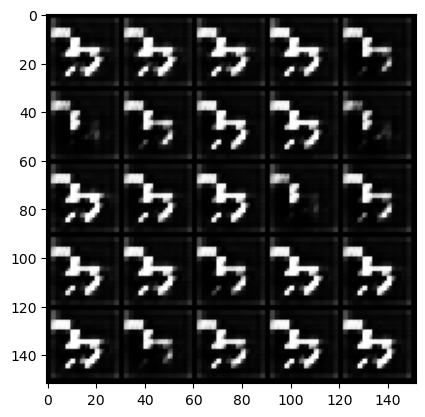

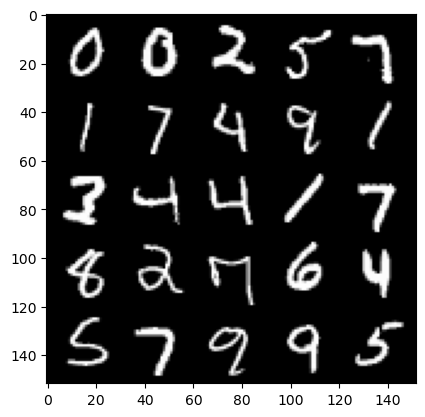

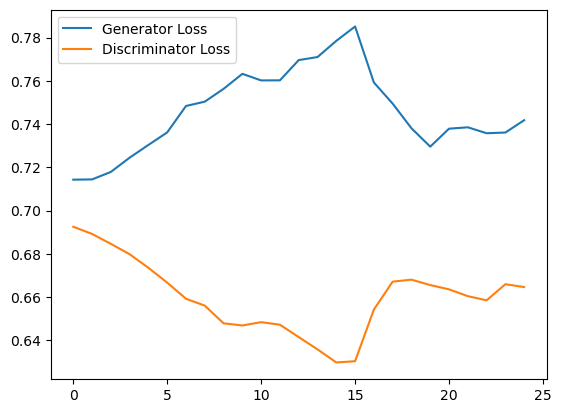

 13%|█▎        | 62/469 [00:05<00:39, 10.35it/s]

Step 1000: Generator loss: 0.7202501418590546, discriminator loss: 0.6789120506048203


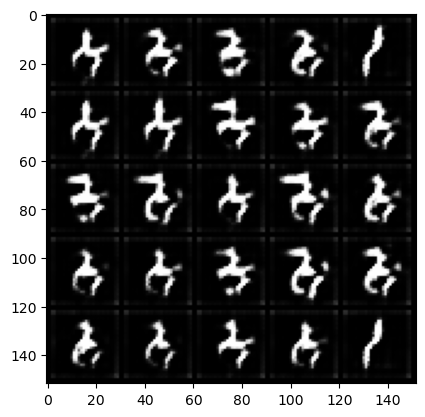

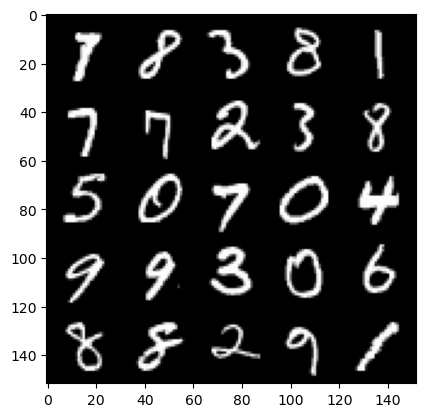

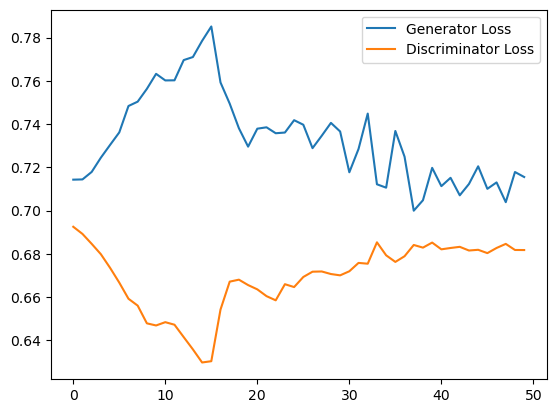

 20%|█▉        | 92/469 [00:08<00:36, 10.34it/s]

Step 1500: Generator loss: 0.7122299638986588, discriminator loss: 0.683717412352562


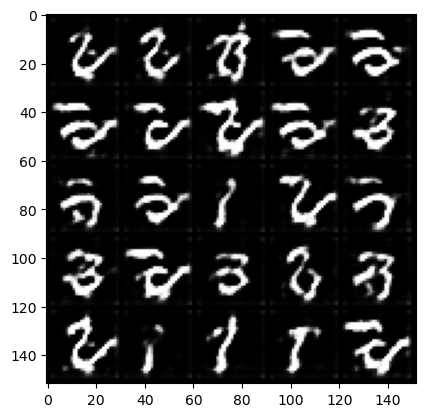

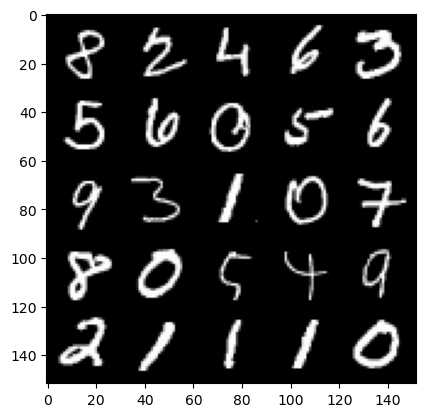

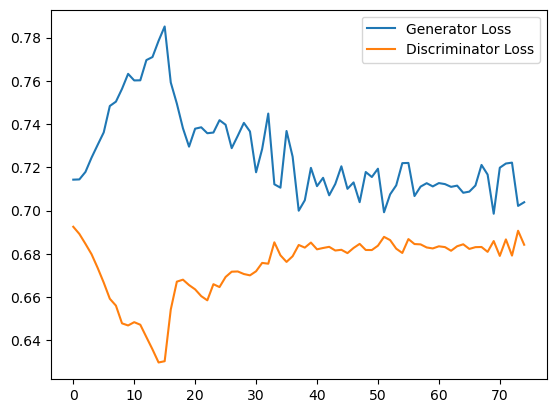

 26%|██▌       | 123/469 [00:13<00:34, 10.13it/s]

Step 2000: Generator loss: 0.711571985244751, discriminator loss: 0.6841532300710678


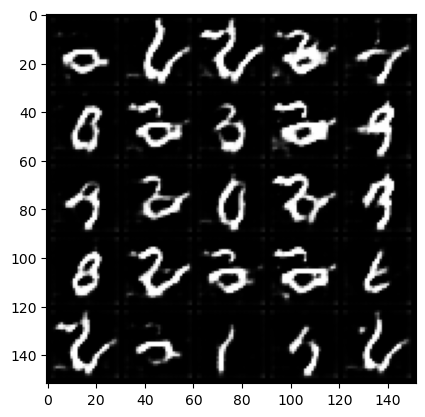

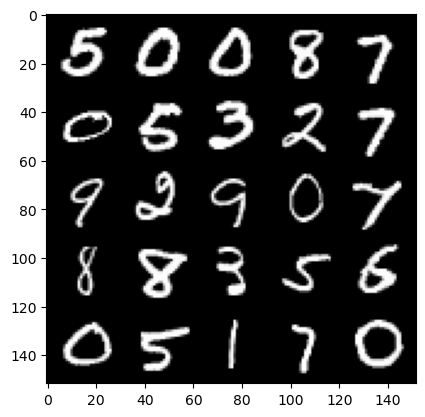

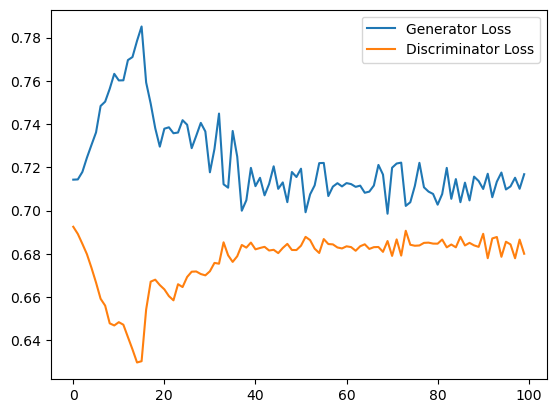

 33%|███▎      | 155/469 [00:16<00:32,  9.76it/s]

Step 2500: Generator loss: 0.7135114566087722, discriminator loss: 0.682783091545105


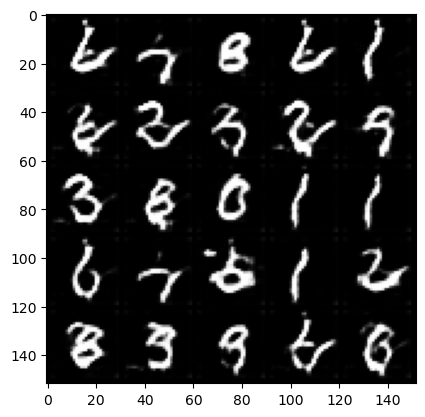

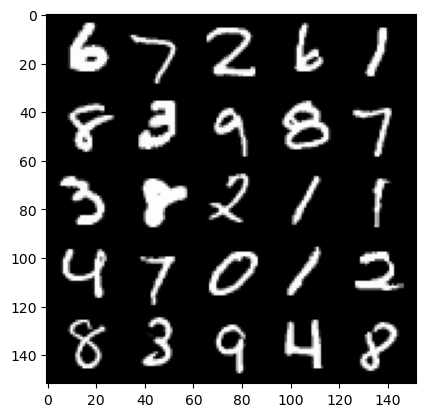

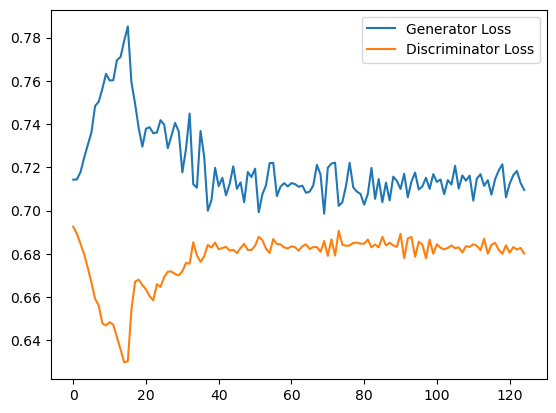

 40%|███▉      | 186/469 [00:19<00:29,  9.49it/s]

Step 3000: Generator loss: 0.715348370552063, discriminator loss: 0.6830291140079499


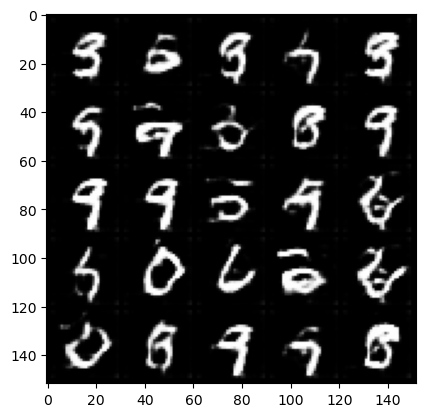

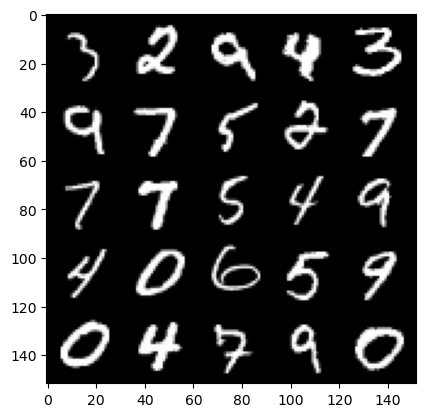

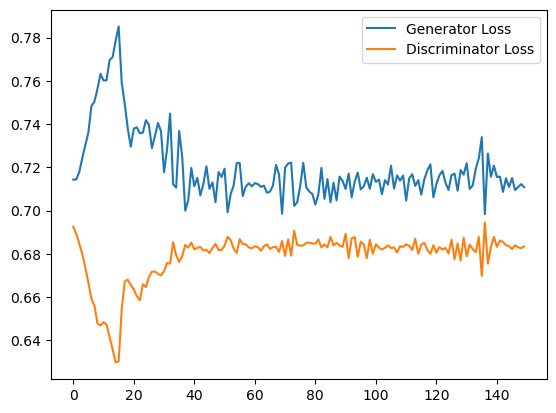

 46%|████▋     | 217/469 [00:23<00:26,  9.68it/s]

Step 3500: Generator loss: 0.7108814140558243, discriminator loss: 0.6849449164867402


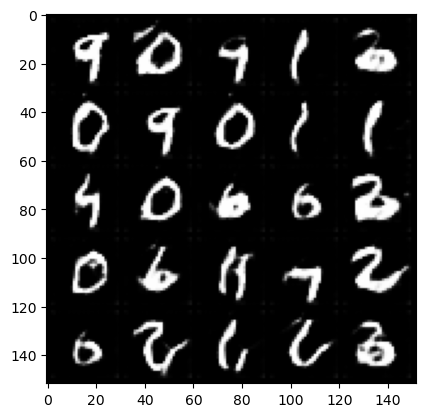

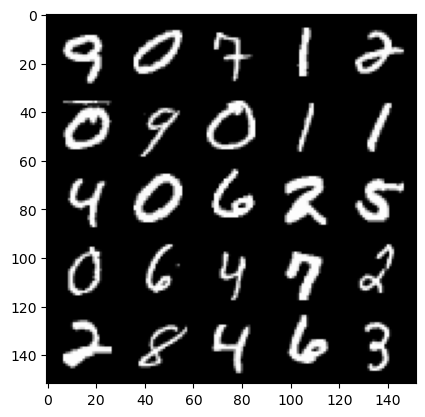

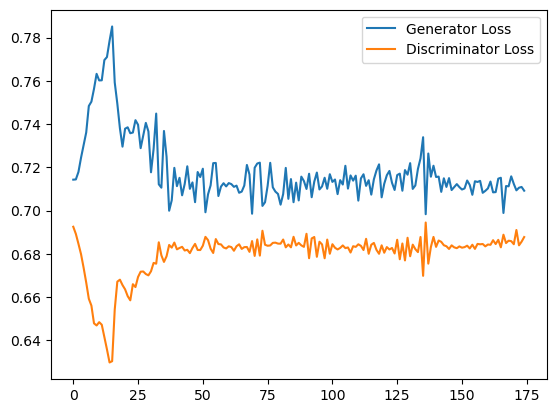

 53%|█████▎    | 248/469 [00:28<00:25,  8.64it/s]

Step 4000: Generator loss: 0.7115696264505387, discriminator loss: 0.6854364787340164


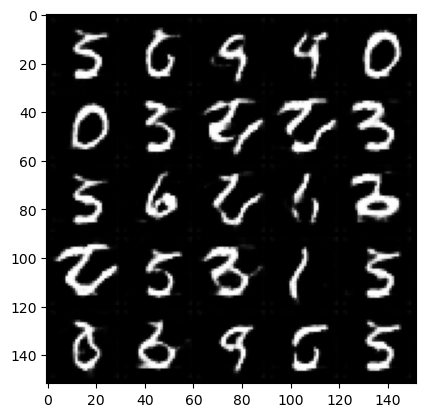

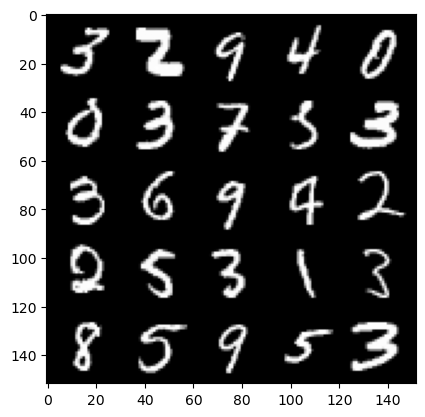

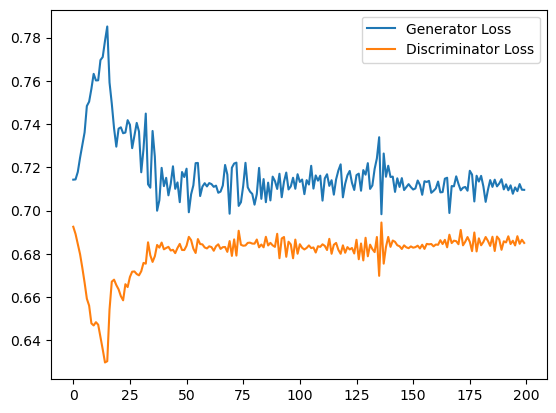

 59%|█████▉    | 279/469 [00:30<00:20,  9.20it/s]

Step 4500: Generator loss: 0.7136476980447769, discriminator loss: 0.6841565500497818


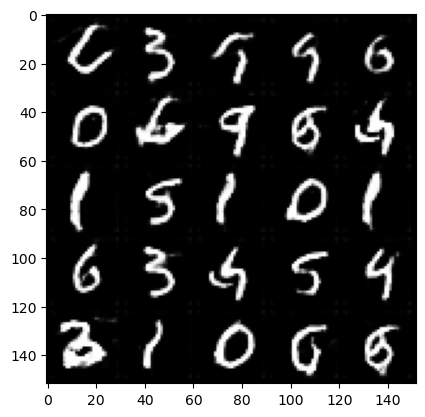

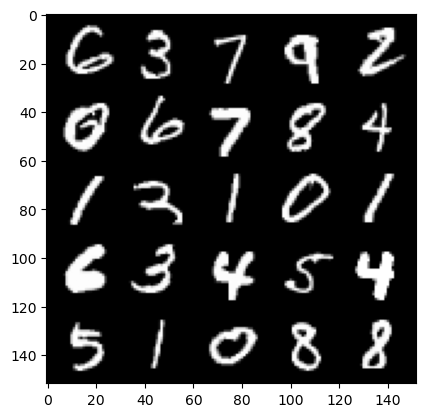

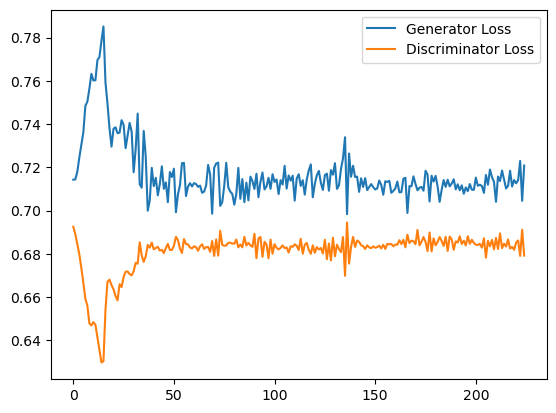

 38%|███▊      | 177/469 [00:21<00:35,  8.25it/s]


KeyboardInterrupt: 

In [48]:
cur_step = 0
mean_generator_loss = []
mean_discriminator_loss = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.to(device)
        disc_opt.zero_grad()
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:,:,None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        noise_and_labels = combine_vectors(fake_noise.to(device), one_hot_labels.to(device))
        fake = gen(noise_and_labels)

        assert len(fake) == len(real)
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)

        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)


        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        mean_discriminator_loss += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        mean_generator_loss += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(mean_generator_loss[-display_step:]) / display_step
            disc_mean = sum(mean_discriminator_loss[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(mean_generator_loss) // step_bins)] * step_bins)
            num_examples = (len(mean_generator_loss) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(mean_generator_loss[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(mean_discriminator_loss[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

# Changing noise vector

In [ ]:
import math


n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()